# Predict Bike Sharing Demand with AutoGluon


## Step 1: Create Kaggle Account and download API key

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached pip-23.1.2-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
  Using cached setuptools-67.8.0-py3-none-any.whl (1.1 MB)
  Using cached wheel-0.40.0-py3-none-any.whl (64 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.3.0
    Uninstalling setuptools-59.3.0:
      Successfully uninstalled setuptools-59.3.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.2
    Uninstalling bokeh-2.4.2:
      Successfully uninstalled bokeh-2.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 153.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.5/292.5 kB 219.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "skully"
kaggle_key = ""

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [ ]:
# We must install kaggle first before we start downloading the data
!pip install kaggle

  Using cached kaggle-1.5.13-py3-none-any.whl
  Using cached python_slugify-8.0.1-py2.py3-none-any.whl (9.7 kB)


In [14]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import pandas as pd
from autogluon.tabular import TabularPredictor

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv")
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# Convert the 'datetime' column to a datetime format
train['datetime'] = pd.to_datetime(train['datetime']) # we could also read the dataset like this "pd.read_csv("train.csv", parse_dates=['datetime'])"

# Check the datatype of the 'datetime' column
print(train['datetime'].dtype)

datetime64[ns]


In [9]:
# Simple output of the train dataset to view some of the min/max/variation of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [ ]:
# Create the test pandas dataframe in pandas by reading the csv, then parse the datetime again
test = pd.read_csv("test.csv")
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
# Convert the 'datetime' column to a datetime format
test['datetime'] = pd.to_datetime(test['datetime'])

# Check the datatype of the 'datetime' column
print(test['datetime'].dtype)

datetime64[ns]


In [12]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [13]:
# Convert the 'datetime' column to a datetime format
submission['datetime'] = pd.to_datetime(submission['datetime'])

# Check the datatype of the 'datetime' column
print(submission['datetime'].dtype)

datetime64[ns]


## Step 3: Train a model using AutoGluon’s Tabular Prediction

* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Set a time limit of 10 minutes (600 seconds) to manage resources.
* Use the preset `best_quality` to focus on creating the best model.

In [14]:
# Drop the unneeded columns
train = train.drop(columns=['casual', 'registered'])

In [15]:
predictor = TabularPredictor(label="count",
                             eval_metric = 'root_mean_squared_error'
                            ).fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230602_132503/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230602_132503/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Apr 25 15:24:19 UTC 2023
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fea

### Review AutoGluon's training run with ranking of models that did the best.

In [16]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.045480      19.019426  549.669949                0.001406           0.598720            3       True         14
1   RandomForestMSE_BAG_L2  -53.380281      15.125412  410.769227                0.616799          28.833908            2       True         12
2          LightGBM_BAG_L2  -54.898932      14.742971  407.816401                0.234358          25.881082            2       True         11
3          CatBoost_BAG_L2  -55.830391      14.580311  436.922523                0.071698          54.987204            2       True         13
4        LightGBMXT_BAG_L2  -60.289907      18.095164  439.369035                3.586551          57.433715            2       True         10
5    KNeighborsDist_BAG_L1  -84.125061       0.103863    0.031142         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54

### Create predictions from test dataset

In [17]:
predictions = predictor.predict(test)
predictions.head()

0    24.086266
1    41.630322
2    45.201138
3    49.157898
4    51.918861
Name: count, dtype: float32

#### Kaggle will reject the submission if we don't set everything to be > 0 so we need to handle that.

In [18]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.684860
std        89.845329
min         3.338909
25%        19.965668
50%        64.152946
75%       168.188019
max       364.928314
Name: count, dtype: float64

In [ ]:
print(predictions) # Sanity Check

0        24.086266
1        41.630322
2        45.201138
3        49.157898
4        51.918861
           ...    
6488    160.519592
6489    160.570572
6490    154.665497
6491    152.288513
6492    150.973450
Name: count, Length: 6493, dtype: float32


In [20]:
import numpy as np
# How many negative values do we have?
num_negative = np.sum(predictions < 0)

print('Number of negative predictions:', num_negative)

Number of negative predictions: 0


In [21]:
# Set them to zero
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [ ]:
submission["count"] = predictions[0]
submission.to_csv("submission.csv", index=False)

In [37]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 190k/190k [00:00<00:00, 342kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [22]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2023-05-31 03:29:56  first raw submission  complete  1.93791      1.93791       
submission.csv  2023-05-31 03:27:21  first raw submission  complete  1.93791      1.93791       


#### Initial score of 1.93791 

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

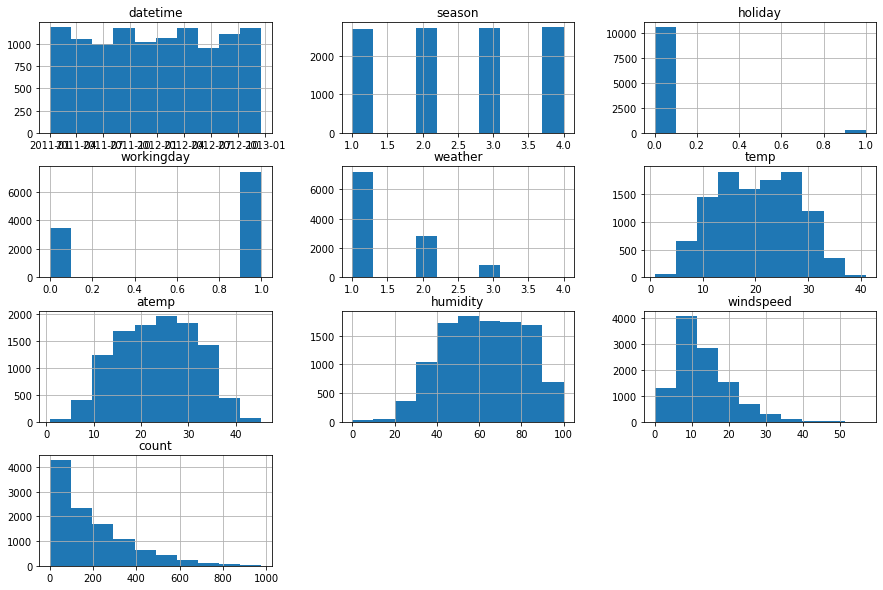

In [ ]:
# Here we create a histogram of all features to show the distribution of each one relative to the data.
train.hist(figsize=(15, 10));

In [ ]:
# create new features
train["year"] = train.datetime.dt.year
train["month"] = train.datetime.dt.month
train["day"] = train.datetime.dt.day
train["hour"] = train.datetime.dt.hour
test["year"] = test.datetime.dt.year
test["month"] = test.datetime.dt.month
test["day"] = test.datetime.dt.day
test["hour"] = test.datetime.dt.hour

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [25]:
train["season"] = train['season'].astype('category')
train["weather"] = train['weather'].astype('category')
test["season"] = test['season'].astype('category')
test["weather"] = test['weather'].astype('category')

In [26]:
# View the new features.
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


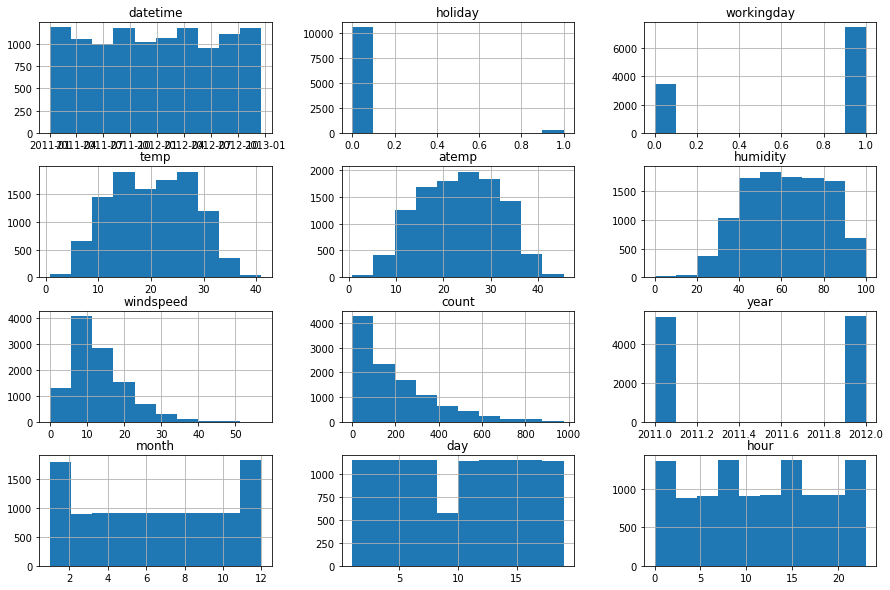

In [27]:
# View histogram of all features again now with the hour feature
# I did not add hour only but I also added year , month and day
train.hist(figsize=(15, 10));

## Step 5: Rerun the model with the same settings as before, just with more features

In [28]:
# Now we ignore date time as we replaced it with 4 additional features.
predictor_new_features = TabularPredictor(label="count",
                                          eval_metric = 'root_mean_squared_error',
                                          learner_kwargs={'ignored_columns':['datetime']}
                            ).fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230602_133600/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230602_133600/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Apr 25 15:24:19 UTC 2023
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fe

In [29]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -35.713702      32.325720  511.931409                0.000907           0.404201            3       True         16
1      WeightedEnsemble_L2  -35.898167      28.180399  351.627246                0.001250           0.822751            2       True          9
2     ExtraTreesMSE_BAG_L2  -35.943119      31.446240  402.643215                0.746213           8.253677            2       True         14
3          CatBoost_BAG_L2  -36.114636      30.792078  451.953069                0.092051          57.563531            2       True         13
4          LightGBM_BAG_L2  -36.223407      30.837591  417.938887                0.137564          23.549349            2       True         11
5   RandomForestMSE_BAG_L2  -36.525417      31.348985  422.160651         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -123.93326033133259,
  'KNeighborsDist_BAG_L1': -119.3656013058328

In [30]:
# Create the predictions from the test set first
predictions_new = predictor_new_features.predict(test)
predictions_new.head()

0    13.828568
1     6.094977
2     5.628566
3     4.573069
4     4.179988
Name: count, dtype: float32

In [ ]:
# set all negative values to zero for submission
num_negative_new = np.sum(predictions_new < 0)
print('Number of negative predictions:', num_negative_new)
predictions_new[predictions_new < 0] = 0

Number of negative predictions: 0


In [34]:
# Same submitting predictions
submission["count"] = predictions_new[0]
submission.to_csv("submission_new_features.csv", index=False)

In [35]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 197k/197k [00:00<00:00, 321kB/s]
Successfully submitted to Bike Sharing Demand

In [37]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2023-06-02 13:51:25  new features          complete  2.32921      2.32921       
submission.csv               2023-05-31 03:29:56  first raw submission  complete  1.93791      1.93791       
submission.csv               2023-05-31 03:27:21  first raw submission  complete  1.93791      1.93791       


#### New Score of 2.32921      

## Step 6: Hyper parameter optimization
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [43]:
hyperparameters = {'GBM': {'num_boost_round': 1000, 'learning_rate': 0.1},
                   'XGB': {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.05}}

In [42]:
predictor_new_hpo = TabularPredictor(label="count",
                                     eval_metric = 'root_mean_squared_error',
                                     learner_kwargs= {'ignored_columns':['datetime']},
                                     
                            ).fit(
    train_data = train,
    time_limit = 1200,
    presets = "best_quality",
    hyperparameter_tune_kwargs = 'auto',
    hyperparameters = hyperparameters    
   
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230602_141701/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "AutogluonModels/ag-20230602_141701/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Apr 25 15:24:19 UTC 2023
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using F

In [44]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2 -37.035616       0.003304  323.588942                0.001598           0.783651            2       True         13
1   WeightedEnsemble_L3 -37.319251       0.004017  632.147921                0.001029           0.829184            3       True         26
2   RandomForest_BAG_L2 -37.597827       0.002413  464.453490                0.000131          10.541876            2       True         20
3    LightGBM_BAG_L2/T5 -37.695949       0.002417  486.050467                0.000136          32.138853            2       True         18
4    LightGBM_BAG_L2/T4 -37.715328       0.002383  487.335108                0.000102          33.423494            2       True         17
5    LightGBM_BAG_L2/T3 -37.733270       0.002380  484.946493                0.000098          31.

{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T6': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L1': 'StackerEnsembleModel_RF',
  'XGBoost_BAG_L1/T1': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T2': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T3': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T4': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T5': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T5': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T6': 'StackerEnse

In [45]:
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.head()

0    17.165802
1    -2.436475
2    -4.826913
3     0.145249
4     0.007756
Name: count, dtype: float32

In [46]:
# Remember to set all negative values to zero
num_negative_new_hpo = np.sum(predictions_new_hpo < 0)
print('Number of negative predictions:', num_negative_new_hpo)
predictions_new_hpo[predictions_new_hpo < 0] = 0

Number of negative predictions: 132


In [ ]:
# Same submitting predictions
submission["count"] = predictions_new_hpo[0]
submission.to_csv("submission_new_hpo.csv", index=False)

In [48]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 190k/190k [00:00<00:00, 416kB/s]
Successfully submitted to Bike Sharing Demand

In [50]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-06-02 14:32:05  new features with hyperparameters  complete  2.17146      2.17146       
submission_new_features.csv  2023-06-02 13:51:25  new features                       complete  2.32921      2.32921       
submission.csv               2023-05-31 03:29:56  first raw submission               complete  1.93791      1.93791       
submission.csv               2023-05-31 03:27:21  first raw submission               complete  1.93791      1.93791       


#### New Score of 2.17146

## Step 7: Creating plots and table for report

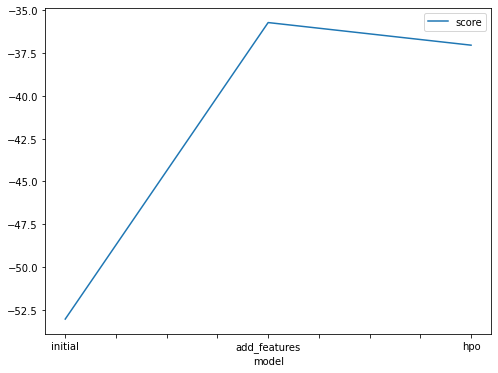

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-53.045480 , -35.713702 , -37.035616]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

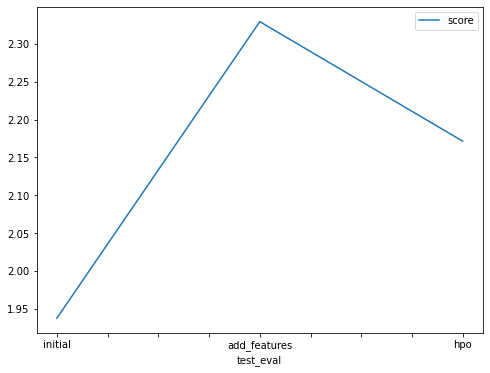

In [52]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.93791, 2.32921, 2.17146]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [53]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["default", "default", "'num_boost_round': 1000, 'learning_rate': 0.1"],
    "hpo2": ["default", "default", "'n_estimators': 100, 'max_depth': 10"],
    "hpo3": ["default", "default","Run time = 20 min"],
    "score": [1.93791, 2.32921, 2.17146]
})

,model,hpo1,hpo2,hpo3,score
0,initial,default,default,default,1.93791
1,add_features,default,default,default,2.32921
2,hpo,"'num_boost_round': 1000, 'learning_rate': 0.1","'n_estimators': 100, 'max_depth': 10",Run time = 20 min,2.17146
